Load dataset and select target columns

In [19]:
import pandas as pd
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("model").getOrCreate()
df = spark.read.parquet("../data/gold/games/").toPandas() #Multi-season
df['game_date'] = pd.to_datetime(df['game_date'])
df = df.sort_values('game_date')

print(f"Dataset: {df.shape} | Columns: {list(df.columns)}\n")

# 1. Features (only *_avg + context)
feat_cols = [c for c in df.columns if '_avg' in c.lower()]
print(f"Features: {len(feat_cols)} → {feat_cols[:5]}...")

X = df[feat_cols].fillna(0)  # avg = 0 for EPA
y_win = df['home_win']       # ← Classification 0/1
y_spread = df['final_home_margin'] # ← Regression -10/+7

Dataset: (1688, 53) | Columns: ['game_id', 'game_date', 'week', 'home_team', 'away_team', 'div_game', 'is_playoffs', 'final_home_score', 'final_away_score', 'final_total_score', 'final_home_margin', 'home_win', 'total_pass_plays', 'total_rush_plays', 'total_offensive_yards', 'avg_epa_per_play', 'home_off_epa_last_4_games_avg', 'home_off_epa_season_avg', 'home_team_plays_last_4_games_avg', 'home_team_plays_season_avg', 'home_points_scored_last_4_games_avg', 'home_points_scored_season_avg', 'home_pass_yds_last_4_games_avg', 'home_pass_yds_season_avg', 'home_rush_yds_last_4_games_avg', 'home_rush_yds_season_avg', 'home_def_epa_last_4_games_avg', 'home_def_epa_season_avg', 'home_def_allowed_last_4_games_avg', 'home_def_allowed_season_avg', 'home_def_allowed_pass_yds_last_4_games_avg', 'home_def_allowed_pass_yds_season_avg', 'home_def_allowed_rush_yds_last_4_games_avg', 'home_def_allowed_rush_yds_season_avg', 'away_off_epa_last_4_games_avg', 'away_off_epa_season_avg', 'away_team_plays_last_


🏈 NFL PREDICTIVE MODEL - DATA SPLIT SUMMARY 🏈
📊 TOTAL GAMES: 1,688
🎯 FEATURES: 36 (EPA, Points, Yards Off/Def)
------------------------------------------------------------
> TRAINING SET (2020-2023 seasons): 838 games | (838, 36)
> VALIDATION SET (2024 season):    285 games  | (285, 36)
> TEST SET (2025 season):    565 games | (565, 36)
------------------------------------------------------------
⚡ Baseline (Home Win %): 53.4%

🏆 RESULTS: HOME WIN | Validation: 57.9% accuracy | Test: 60.0% accuracy
📊 RESULTS: SPREAD MAE | Validation: 11.6 | Test: 10.7 points


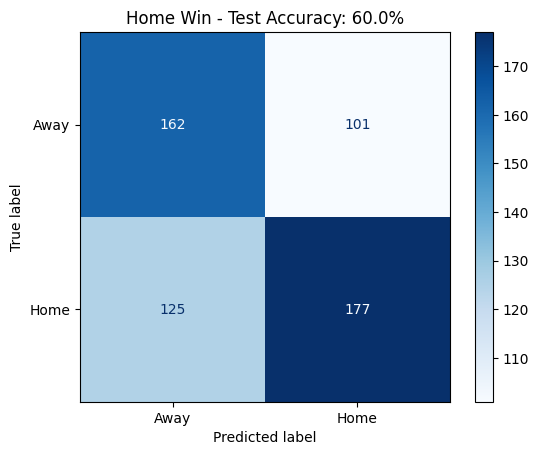

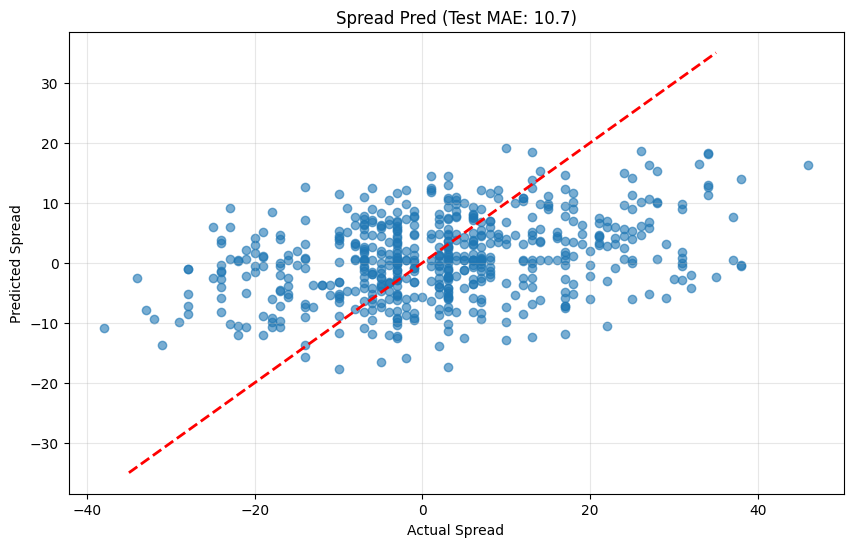

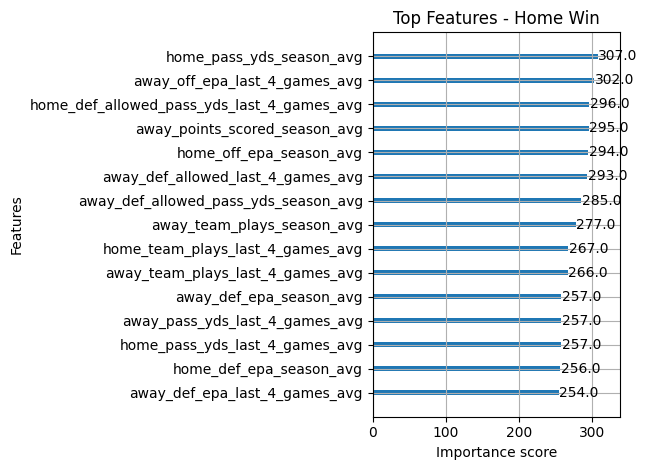

In [32]:
# 2. Crono-split
train_data = df[df['season'] <= 2022]
val_data = df[df['season'] == 2023]
test_data = df[df['season'] >= 2024]

# Extrae X/y por split
X_train, y_train_win, y_train_spread = X.loc[train_data.index], y_win.loc[train_data.index], y_spread.loc[train_data.index]
X_val, y_val_win, y_val_spread = X.loc[val_data.index], y_win.loc[val_data.index], y_spread.loc[val_data.index]
X_test, y_test_win, y_test_spread = X.loc[test_data.index], y_win.loc[test_data.index], y_spread.loc[test_data.index]

# 3. MODELS CON EARLY STOPPING (usa val!)
# Home Win Classification
model_win = xgb.XGBClassifier(
    n_estimators=500, 
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)
model_win.fit(
    X_train, y_train_win,
    eval_set=[(X_val, y_val_win)],
    verbose=False
)
preds_win_val = model_win.predict(X_val)
preds_win_test = model_win.predict(X_test)

print("\n" + "="*60)
print("🏈 NFL PREDICTIVE MODEL - DATA SPLIT SUMMARY 🏈")
print("="*60)
print(f"📊 TOTAL GAMES: {len(df):,}")
print(f"🎯 FEATURES: {len(feat_cols)} (EPA, Points, Yards Off/Def)")
print("-"*60)
print(f"> TRAINING SET (2020-2023 seasons): {len(train_data):,} games | {X_train.shape}")
print(f"> VALIDATION SET (2024 season):    {len(val_data):,} games  | {X_val.shape}")
print(f"> TEST SET (2025 season):    {len(test_data):,} games | {X_test.shape}")
print("-"*60)
print(f"⚡ Baseline (Home Win %): {df['home_win'].mean():.1%}")
print("="*60 + "\n")
acc_val = accuracy_score(y_val_win, preds_win_val)
acc_test = accuracy_score(y_test_win, preds_win_test)
print(f"🏆 RESULTS: HOME WIN | Validation: {acc_val:.1%} accuracy | Test: {acc_test:.1%} accuracy")

# Spread Regression
model_spread = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
model_spread.fit(
    X_train, y_train_spread,
    eval_set=[(X_val, y_val_spread)],
    verbose=False
)
preds_spread_val = model_spread.predict(X_val)
preds_spread_test = model_spread.predict(X_test)

mae_val = mean_absolute_error(y_val_spread, preds_spread_val)
mae_test = mean_absolute_error(y_test_spread, preds_spread_test)
print(f"📊 RESULTS: SPREAD MAE | Validation: {mae_val:.1f} | Test: {mae_test:.1f} points")

# 4. VISUALS (solo test set)
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, mean_absolute_error

# Confusion Matrix (test)
cm = confusion_matrix(y_test_win, preds_win_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away', 'Home']).plot(cmap='Blues')
plt.title(f'Home Win - Test Accuracy: {acc_test:.1%}')
plt.show()

# Spread scatter (test)
plt.figure(figsize=(10,6))
plt.scatter(y_test_spread, preds_spread_test, alpha=0.6)
plt.plot([-35,35], [-35,35], 'r--', lw=2)
plt.xlabel('Actual Spread'); plt.ylabel('Predicted Spread')
plt.title(f'Spread Pred (Test MAE: {mae_test:.1f})')
plt.grid(True, alpha=0.3)
plt.show()

# 5. FEATURE IMPORTANCE (top 15)
xgb.plot_importance(model_win, max_num_features=15, title="Top Features - Home Win")
plt.tight_layout()
plt.show()